## Description
This notebook is a test of the Monte Carlo simulation of temperature data by using different implementations.


In [33]:
import numpy as np
from tqdm import tqdm
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.style import reload_library

from compstat_research.config import PROCESSED_DATA_DIR, MPLSTYLE_DIR

reload_library()
plt.style.use(MPLSTYLE_DIR / "iragca_cmr10.mplstyle")

In [2]:
data_dir = PROCESSED_DATA_DIR / "cds" / "era5" / "2m-temperature" / "global"

daily_temp = pl.read_parquet(data_dir / "era5-2m-temperature-global-daily-avg.parquet")
yearly_temp = pl.read_parquet(data_dir / "era5-2m-temperature-global-yearly-avg.parquet")
daily_temp.head()

temp_year,temp_month,temp_day,avg_temp
i64,i64,i64,f64
1940,1,2,276.007051
1940,1,3,275.975732
1940,1,4,275.934177
1940,1,5,275.893011
1940,1,6,275.7141


In [14]:
daily_temp.shape

(31046, 4)

## Base Implementation, very slow

# Without vectorization, base python lists : 6:11 
# Without vectorizaion, base python mapping: 5:46
# With vectorizaiton, base numpy 

In [8]:
iterations = []
for iteration in tqdm(range(100)):
    yearly_avg_temps = []
    for year in range(85):
        day_temps = map(lambda x: daily_temp["avg_temp"].sample(1).item(), range(365))
        yearly_avg_temps.append(sum(day_temps) / 365)

    iterations.append(yearly_avg_temps)

100%|██████████| 100/100 [05:46<00:00,  3.46s/it]


In [3]:
iterations = []
for iteration in tqdm(range(100)):
    yearly_avg_temps = []
    for year in range(85):
        day_temps = []
        for day in range(365):
            day_temps.append(daily_temp["avg_temp"].sample(1).item())
        yearly_avg_temps.append(sum(day_temps) / 365)
    iterations.append(yearly_avg_temps)

  5%|▌         | 5/100 [00:19<06:08,  3.88s/it]


KeyboardInterrupt: 

Text(0, 1, 'Average Temperature (K)')

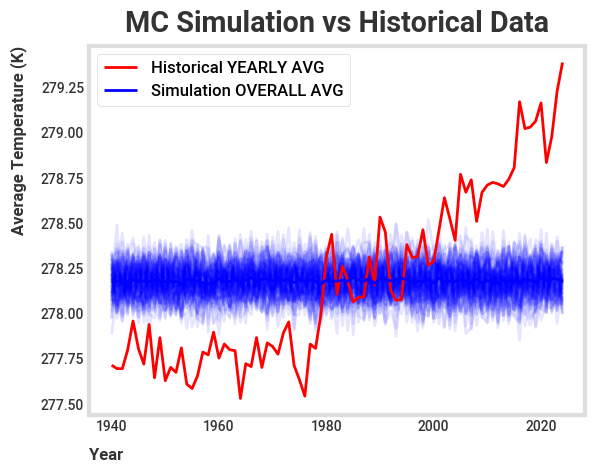

In [20]:
for iteration in iterations:
    sns.lineplot(x=range(1940, 1940 + 85), y=iteration, alpha=0.1, color='blue', label='_nolegend_')

# Plot historical data
sns.lineplot(data=yearly_temp, x="temp_year", y="avg_temp", 
            color='red', label='Historical YEARLY AVG')
# Plot mean of simulations
sns.lineplot(x=range(1940, 1940 + 85), y=np.array(iterations).mean(axis=0), 
            color='blue', label='Simulation OVERALL AVG')
plt.title('MC Simulation vs Historical Data')
plt.xlabel('Year')
plt.ylabel('Average Temperature (K)')

## Numpy implementation, blazingly fast

In [9]:
def simulate_daily_temperatures(temp_data, n_days):
    """Simulate daily temperatures by randomly sampling from historical data."""
    return np.random.choice(temp_data["avg_temp"], size=n_days)

def simulate_yearly_averages(temp_data, start_year, n_years, n_iterations=100):
    """
    Run Monte Carlo simulation for yearly temperature averages.
    
    Args:
        temp_data: Polars DataFrame with historical temperature data
        start_year: First year of the simulation
        n_years: Number of years to simulate
        n_iterations: Number of Monte Carlo iterations
    
    Returns:
        tuple: (years array, simulated temperatures array [iterations x years])
    """
    DAYS_PER_YEAR = 365
    years = np.arange(start_year, start_year + n_years)
    
    # Pre-allocate array for all iterations [iterations x years]
    results = np.zeros((n_iterations, n_years))
    
    for i in tqdm(range(n_iterations), unit="iterations"):
        # Simulate daily temperatures for all years at once
        daily_temps = simulate_daily_temperatures(temp_data, n_years * DAYS_PER_YEAR)
        # Reshape to [n_years x days_per_year] and compute yearly averages
        yearly_temps = daily_temps.reshape(n_years, DAYS_PER_YEAR).mean(axis=1)
        results[i] = yearly_temps
    
    return years, results

In [13]:
import time
start_time = time.time()
years, simulated_data = simulate_yearly_averages(
    temp_data=daily_temp,
    start_year=1940,
    n_years=85,
    n_iterations=100
)
print(f"Time taken: {time.time() - start_time:.2f} seconds")



100%|██████████| 100/100 [00:00<00:00, 2500.02iterations/s]

Time taken: 0.04 seconds


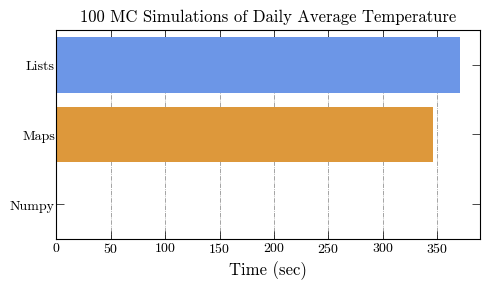

In [32]:
from compstat_research.config import FIGURES_DIR

comparison = pl.DataFrame({
    "Time (sec)" : [371.0,346.0,0.04],
    "Implementation" : [
        "Lists",
        "Maps",
        "Numpy",
    ],
})

# Create the plot with custom labels
sns.barplot(data=comparison, y="Implementation", x="Time (sec)", orient="h", hue="Implementation")
# plt.yticks([])
plt.ylabel("")
plt.title("100 MC Simulations of Daily Average Temperature")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "numpy_vs_lists_vs_maps.svg", transparent=True)

Text(0, 1, 'Average Temperature (K)')

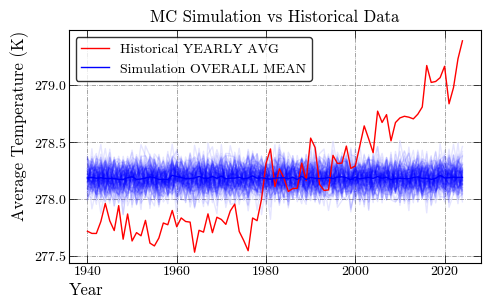

In [5]:
# plt.figure(figsize=(12, 6))
# Plot all Monte Carlo iterations (lighter color)
for iteration in simulated_data:
    sns.lineplot(x=years, y=iteration, alpha=0.1, color='blue', label='_nolegend_')
# Plot historical data
sns.lineplot(data=yearly_temp, x="temp_year", y="avg_temp", 
            color='red', label='Historical YEARLY AVG')
# Plot mean of simulations
sns.lineplot(x=years, y=simulated_data.mean(axis=0), 
             
            color='blue', label='Simulation OVERALL MEAN')
plt.title('MC Simulation vs Historical Data')
plt.xlabel('Year')
plt.ylabel('Average Temperature (K)')

## Estimating Pi

2025-02-21 11:10:07.049 | INFO     | compstat_research.config:<module>:11 - PROJ_ROOT path is: D:\Documents\3 Production Save Files\1 Cloned repositories\compstat-research
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
d:\Documents\3 Production Save Files\1 Cloned repositories\compstat-research\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 960 (\N{GREEK SMALL LETTER PI}) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Documents\3 Production Save Files\1 Cloned repositories\compstat-research\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8776 (\N{ALMOST EQUAL TO}) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


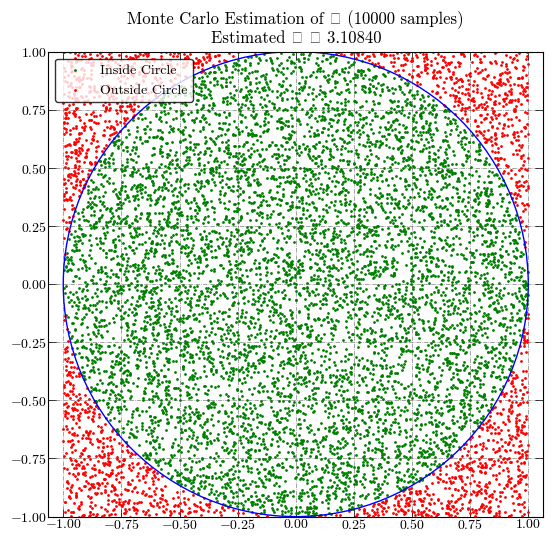

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
from compstat_research.config import MPLSTYLE_DIR
mplstyle.reload_library()
plt.style.use(MPLSTYLE_DIR / "iragca_cmr10.mplstyle")

def monte_carlo_pi(num_samples=10000):
    inside_circle = 0
    x_inside, y_inside = [], []
    x_outside, y_outside = [], []

    for _ in range(num_samples):
        x, y = np.random.uniform(-1, 1, 2)  # Generate random (x, y) points

        if x**2 + y**2 <= 1:
            inside_circle += 1
            x_inside.append(x)
            y_inside.append(y)
        else:
            x_outside.append(x)
            y_outside.append(y)

    pi_estimate = (inside_circle / num_samples) * 4  # Estimating π
    return pi_estimate, x_inside, y_inside, x_outside, y_outside

# Run simulation
num_samples = 10000
pi_estimate, x_in, y_in, x_out, y_out = monte_carlo_pi(num_samples)

# Plot results
plt.figure(figsize=(6,6))
plt.scatter(x_in, y_in, color='green', s=1, label="Inside Circle")
plt.scatter(x_out, y_out, color='red', s=1, label="Outside Circle")
circle = plt.Circle((0, 0), 1, color='blue', fill=False)
plt.gca().add_patch(circle)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.title(f"Monte Carlo Estimation of π ({num_samples} samples)\nEstimated π ≈ {pi_estimate:.5f}")
plt.legend()
plt.show()


## Stock price prediction (GBM)

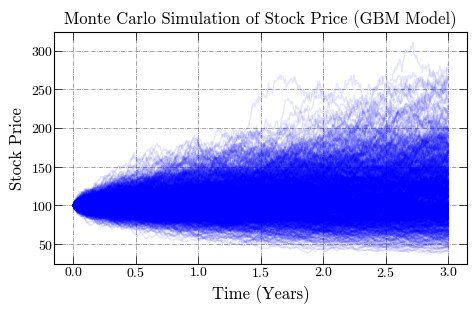

Expected stock price after 3 year(s): $115.15


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
S0 = 100  # Initial stock price
mu = 0.05  # Expected annual return (drift)
sigma = 0.2  # Volatility (standard deviation of returns)
T = 3  # Time period in years
dt = 1/252  # Daily time step (assuming 252 trading days in a year)
N = int(T / dt)  # Number of steps
M = 1000  # Number of simulations

# Monte Carlo Simulation
np.random.seed(42)  # For reproducibility
time = np.linspace(0, T, N)
simulations = np.zeros((M, N))
simulations[:, 0] = S0  # Set initial stock price for all simulations

for i in range(1, N):
    Z = np.random.standard_normal(M)  # Random normal variables
    simulations[:, i] = simulations[:, i-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

# Plot results
plt.plot(time, simulations.T, alpha=0.1, color="blue")
plt.title("Monte Carlo Simulation of Stock Price (GBM Model)")
plt.xlabel("Time (Years)")
plt.ylabel("Stock Price")
plt.show()

# Expected price after T years
expected_price = np.mean(simulations[:, -1])
print(f"Expected stock price after {T} year(s): ${expected_price:.2f}")
